In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from typing import Tuple, Dict
from collections import OrderedDict

import pathlib
import tttrlib
import json
import copy

import tqdm
import numpy as np
import pandas as pd
import pylab as plt

In [3]:
def read_burst_analysis(
        paris_path: pathlib.Path,
        tttr_file_type: str,
        pattern: str = 'b*4*',
        row_stride: int = 1
) -> (pd.DataFrame, Dict[str, tttrlib.TTTR]):
    def update_tttr_dict(data_path, tttrs: Dict[str, tttrlib.TTTR] = dict()):
        for ff, fl in zip(df['First File'], df['Last File']):
            try:
                tttr = tttrs[ff]
            except KeyError:
                fn = str(data_path / ff)
                tttr = tttrlib.TTTR(fn, tttr_file_type)
                tttrs[ff] = tttr
        return tttrs

    info_path = paris_path / 'Info'
    data_path = paris_path.parent

    dfs = list()
    is_first_file = True  # Flag to track the first file
    for path in paris_path.glob(pattern):
        frames = list()
        for fn in sorted(path.glob('*')):
            with open(fn) as f:
                t = f.readlines()
                t = [line.rstrip('\n') for line in t]  # Remove trailing newlines
                h = t[0].split('\t')
                d = [[x for x in l.split('\t')] for l in t[2::row_stride]]
                frames.append(pd.DataFrame(d, columns=h))
        dfs.append(pd.concat(frames))
    df = pd.concat(dfs, axis=1)

    # Loop through each column and attempt to convert to numeric
    for column in df.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            if not is_first_file:  # Ignore conversion errors only for the first file
                print(f"read_burst_analysis: Could not convert {column} to numeric")
        is_first_file = False  # After processing the first file, set flag to False

    tttrs = dict()
    update_tttr_dict(data_path, tttrs)
    return df, tttrs


In [4]:
def get_tttr_mask(tttr, micro_time_range, detector_chs):
    mt_start, mt_stop = micro_time_range
    mt = tttr.micro_times
    ch = tttr.routing_channels
    mt_time_mask = np.zeros_like(mt, dtype=bool)
    mt_time_mask |= (mt >= mt_start) & (mt <= mt_stop)
    routing_mask = np.isin(ch, detector_chs)
    combined_mask = mt_time_mask & routing_mask
    return np.where(combined_mask > 0)[0]

In [5]:
def make_jordi(
    tttr_files, 
    tttr_file_type, 
    detector_chs, 
    micro_time_range,
    micro_time_binning, 
    save_files: bool = True,
    normalize_counts: bool = False,
    threshold: float = -1
):
    jordis = list()
    for fn in tttr_files:
        irf_tttr = tttrlib.TTTR(fn, tttr_file_type)
        
        t_p = filter_tttr(irf_tttr, micro_time_range, detector_chs[::2])
        t_s = filter_tttr(irf_tttr, micro_time_range, detector_chs[1::2])
        
        c_p = t_p.get_microtime_histogram(micro_time_binning)[0][:micro_time_range[1] // micro_time_binning]
        c_s = t_s.get_microtime_histogram(micro_time_binning)[0][:micro_time_range[1] // micro_time_binning]

        max_cp = np.max(c_p)
        max_cs = np.max(c_s)
        
        if threshold > 0.0:
            c_p[c_p < threshold * max_cp] = 0.0
            c_s[c_p < threshold * max_cs] = 0.0
        
        if normalize_counts:
            c_p /= np.sum(c_p)
            c_s /= np.sum(c_s)
    
        # Make JORDI
        jordi = np.hstack([c_p, c_s])
        jordi /= 2
        jordis.append(jordi)
        
        if save_files:
            target_fn = pathlib.Path(fn).with_suffix('').as_posix() + '_' + ''.join([str(x) for x in detector_chs]) + '.dat'
            np.savetxt(target_fn, jordi)
    
    return jordis

In [6]:
def make_2d_plot(
    x, y, 
    range_x,
    range_y,
    paris_folder: pathlib.Path,
    xlabel: str = "x", 
    ylabel: str = "y",
    bins_x: int = 100,
    bins_y: int = 100,
    log_x: bool = False,
    log_y: bool = False
): 
    # Define logarithmic bins if required
    if log_x:
        bins_x = np.logspace(np.log10(range_x[0]), np.log10(range_x[1]), bins_x)
    else:
        bins_x = np.linspace(range_x[0], range_x[1], bins_x)
        
    if log_y:
        bins_y = np.logspace(np.log10(range_y[0]), np.log10(range_y[1]), bins_y)
    else:
        bins_y = np.linspace(range_y[0], range_y[1], bins_y)
    
    # 1. Define function for 2D histogram (e.g., for SPIE vs EFRET)
    def scatter_hist(x, y, ax, ax_histx, ax_histy):
        # Labels of the marginal distribution
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        
        # 2D histogram with optional log scaling
        hist2D = ax.hist2d(x, y, bins=[bins_x, bins_y], cmap='Greys', density=False)
        
        # Marginal distributions
        xhist = ax_histx.hist(x, bins=bins_x, color="dimgrey")
        yhist = ax_histy.hist(y, bins=bins_y, color="darkorange", orientation='horizontal')
    
        return hist2D, xhist, yhist
    
    # 2. Define a grid
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    
    # 3. Plot the results
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_axes(rect_scatter)
    ax.set_xlabel(xlabel, fontsize=16,  fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=16,  fontweight='bold')
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    # Apply log scaling to the axes if required
    if log_x:
        ax.set_xscale("log")
        ax_histx.set_xscale("log")
    if log_y:
        ax.set_yscale("log")
        ax_histy.set_yscale("log")

    # Set font sizes for tick labels
    for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax_histx.get_yticklabels() + ax_histy.get_xticklabels()):
        label.set_fontsize(14)

    # 4. Plot and save plot
    filename = paris_folder.as_posix() + "/"
    xy2D, x_1D, y_1D = scatter_hist(x, y, ax, ax_histx, ax_histy)
    
    plt.savefig(filename + '2D_' + xlabel + '-' + ylabel + '.png')
    plt.show()
    plt.close()


In [7]:
def filter_tttr(tttr, micro_time_range, detector_chs):
    tttr_filtered = tttr[get_tttr_mask(tttr, micro_time_range, detector_chs)]
    return tttr_filtered

# Inputs

In [8]:
tttr_file_type = 'SPC-130'           # Type of TTTR file (PTU, SPC-130, etc.)    
file_type_ending = '*.spc'           # Ending of file type (used for open IRFs, background measurements)

# Analysis folder containing the burst selection
analysis_path = '/Users/tpeulen/Desktop/ChiSurf_Paper/Figures/Burbulator/fast_pattern/burstwise_All 0.2000#60/'

# Folder containing IRF measurement
irf_folder = '/Users/tpeulen/scp132/10-02-01/H2O'

# Folder containing the background measurement
bg_folder = '/Users/tpeulen/scp132/10-02-01/TRIS'

detector_chs = [8, 0]                # Definition of routing channels. Alternating parallel, perpendicular
micro_time_range = [0, 3600]         # Used micro time channels for convolution
dt = 0.004069                        # Time-resolution of micro time. If None reads from header
micro_time_binning = 16              # Binning of micro time befor convolution
convolution_stop = -1                # Stop channel for convolution. If -1 does full convolution
detector_name = 'green'              # Name of detector
irf_min_threshold = 0.02             # Threshold to discriminate background in IRF
excitation_period = 1./ 73.55 * 1000 # In units of nano seconds. Usually 1./rep rate

g_factor = 1.08316                   # Setup-dependent anisotropy G-factor
l1 = 30.80000000E-3                  # Setup-dependent mixing factor for depolarization in objective
l2 = 36.80000000E-3                  # Setup-dependent mixing factor for depolarization in objective

# Initial values for fits
tau   = 4.0                          # Fluorescence lifetime
gamma = 0.1                          # Fraction of scattered light (background)
r0    = 0.38                         # Fundamental anisotropy
rho   = 1.22                         # Rotational correlation time

# Fix of free parameters of fit. Order: tau, gamma, r0, rho
fixed = [0, 0, 1, 0]

minimum_photons = 60                 # Minimum number of photons for a fit

In [9]:
# Create output folder
analysis_path = pathlib.Path(analysis_path)
file_ending = str('b' + detector_name[0] + '4')
output_dir = analysis_path / file_ending
output_dir.mkdir(exist_ok=True, parents=True)

# Read Data

In [10]:
irf_files = [str(x) for x in pathlib.Path(irf_folder).glob(file_type_ending)]
bg_files = [str(x) for x in pathlib.Path(bg_folder).glob(file_type_ending)]

assert len(irf_files) > 0
assert len(bg_files) > 0

# Read burst information and the tttr files of identified bursts
paris_path = pathlib.Path(analysis_path)
df, tttrs = read_burst_analysis(paris_path, tttr_file_type, pattern='bur')

AssertionError: 

In [29]:
len(df)

5304

In [10]:
# Compute actual dt (including binning)
tttr_header = list(tttrs.values())[0].header
if dt is None:
    dt = tttr_header.micro_time_resolution * micro_time_binning * 1e9 # Use nanoseconds
dt *= micro_time_binning

# Prepare files

In [11]:
# Compute IRF and BG JORDIs
irfs = make_jordi(irf_files, tttr_file_type, detector_chs, micro_time_range, micro_time_binning, normalize_counts=True, threshold=irf_min_threshold)
bgs = make_jordi(bg_files, tttr_file_type, detector_chs, micro_time_range, micro_time_binning)
# Normalize normalizes individually for bg normalize globally

In [12]:
irf_np = np.sum(irfs, axis=0) / len(irfs) * 2.0
bg_np = np.sum(bgs, axis=0) / len(bgs)
bg_np /= sum(bg_np) / 2.0
t = np.arange(len(irf_np) // 2) * dt

irf_np = irf_np
bg_np = bg_np

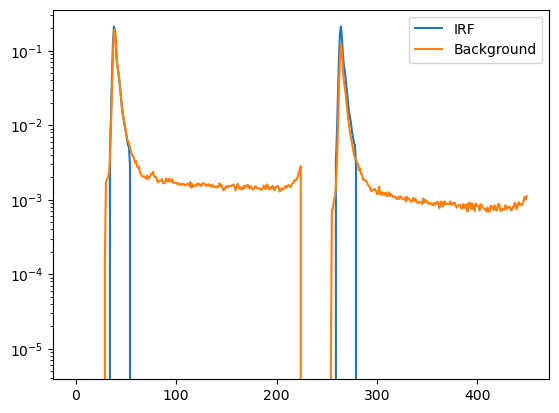

In [13]:
# Plot IRFs and Bg
plt.semilogy(irf_np, label='IRF')
plt.semilogy(bg_np, label='Background')
plt.legend()

2.620197166926058

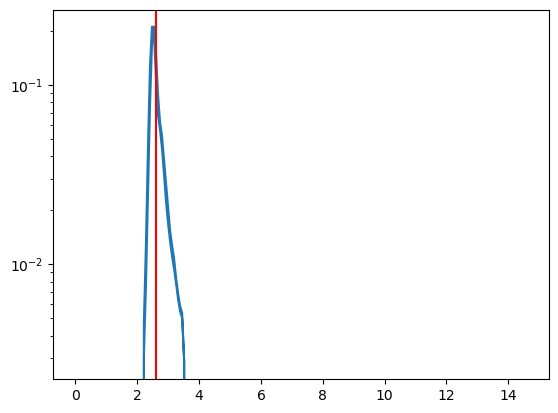

In [14]:
irf_mean_time = irf_np @ np.hstack([t, t]) / 2.0
plt.semilogy(np.hstack([t, t]), irf_np)
plt.axvline(x=irf_mean_time, color='r')
irf_mean_time

# Create fit instance

In [15]:
# Define initial values
x0 = np.array([tau, gamma, r0, rho])
fixed_np = np.array(fixed)

In [16]:
# Create the initial OrderedDict
row_data_template = OrderedDict([
    (f"N{detector_name[0]}-p-all", 0),
    (f"N{detector_name[0]}-s-all", 0),
    (f"Number of Photons (fit window) ({detector_name})", 0),
    (f"2I*  ({detector_name})", 1000.0),
    (f"Tau ({detector_name})", 1000.0),
    (f"gamma ({detector_name})", 1000.0),
    (f"r0 ({detector_name})", 1000.0),
    (f"rho ({detector_name})", 1000.0),
    (f"BIFL scatter? ({detector_name})", True),
    (f"2I*: P+2S? ({detector_name})", True),
    (f"r Scatter ({detector_name})", 1000.0),
    (f"r Experimental ({detector_name})", 1000.0),
    (f"Mean microtime ({detector_name})", 1000.0)
])

# Control plots

In [17]:
# Create a fit instance
fit = tttrlib.Fit23(
    dt=dt,
    irf=irf_np,
    background=bg_np,
    period=excitation_period,
    g_factor=g_factor,
    l1=l1, l2=l2
)

# Iterate over all bursts
summary_data = []
for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    # Prepare the data / find the tttr file
    ff, fl = row['First File'], row['Last File']
    tttr = tttrs[ff]
    
    # Select events within burst
    burst_start, burst_stop = int(row['First Photon']), int(row['Last Photon'])
    burst_tttr = tttr[burst_start:burst_stop]

    # Select P, S in burst
    burst_p = filter_tttr(burst_tttr, micro_time_range, detector_chs[::2])
    burst_s = filter_tttr(burst_tttr, micro_time_range, detector_chs[1::2])

    # Compute microtime histogram
    cp = burst_p.get_microtime_histogram(micro_time_binning)[0][:micro_time_range[1] // micro_time_binning]
    cs = burst_s.get_microtime_histogram(micro_time_binning)[0][:micro_time_range[1] // micro_time_binning]
    cps = cp + cs

    # Compute number of photons
    Np = cp.sum()
    Ns = cs.sum()
    Nt = Np + Ns
    
    # Compute mean arrival time
    mean_micro_time = ((cps @ t) / Nt - irf_mean_time)
    
    # Save data to output dict
    row_data = copy.copy(row_data_template)
    row_data[f"N{detector_name[0]}-p-all"] = Np
    row_data[f"N{detector_name[0]}-s-all"] = Ns
    row_data[f"Number of Photons (fit window) ({detector_name})"] = Nt
    row_data[f"Mean microtime ({detector_name})"] = mean_micro_time

    # If enough photons, fit a lifetime
    if Nt > minimum_photons:
        c_jordi = np.hstack([cp, cs])
        r = fit(data=c_jordi, initial_values=x0, fixed=fixed_np)
        row_data[f"2I*  ({detector_name})"] = r['twoIstar']
        row_data[f"Tau ({detector_name})"] = r['x'][0]
        row_data[f"gamma ({detector_name})"] = r['x'][1]
        row_data[f"r0 ({detector_name})"] = r['x'][2]
        row_data[f"rho ({detector_name})"] = r['x'][3]
        row_data[f"BIFL scatter? ({detector_name})"] = r['x'][4]
        row_data[f"2I*: P+2S? ({detector_name})"] = r['x'][5]
        row_data[f"r Scatter ({detector_name})"] = r['x'][6]
        row_data[f"r Experimental ({detector_name})"] = r['x'][7]
        
    summary_data.append(row_data)  # Add the row data to the summary list

lifetime_summary = pd.DataFrame(summary_data)
bfl_filename = output_dir / str(str(pathlib.Path(ff).stem) + '.' + file_ending)
lifetime_summary.to_csv(bfl_filename, sep='\t', index=False)

100%|██████████| 5304/5304 [00:03<00:00, 1464.09it/s]


In [27]:
len(lifetime_summary)

5304

(0.01, 10)

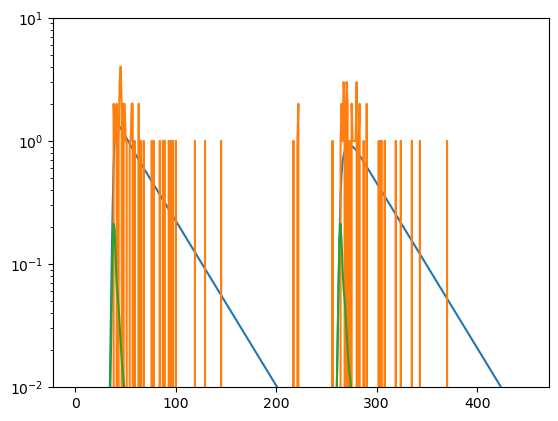

In [19]:
plt.semilogy(fit.model)
plt.semilogy(fit.data)
plt.semilogy(fit.irf)
plt.ylim(0.01, 10)

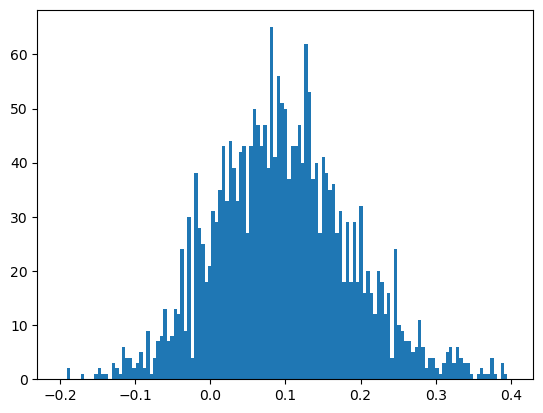

In [20]:
filtered_df = lifetime_summary[lifetime_summary['gamma (green)'] > 0.0]
obs = filtered_df['r Experimental (green)']
_ = plt.hist(obs, range=(-0.2, 0.4), bins=131)

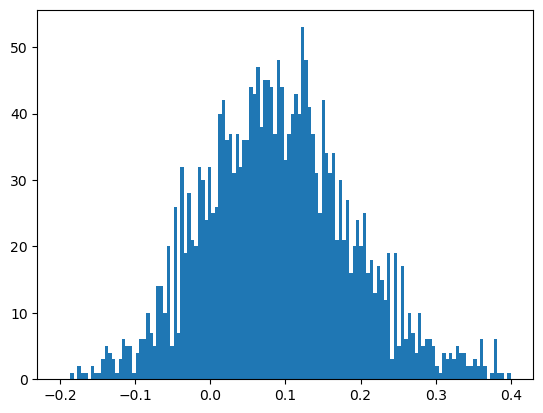

In [21]:
filtered_df = lifetime_summary[lifetime_summary['gamma (green)'] > 0.001]
obs = lifetime_summary['r Scatter (green)']
_ = plt.hist(obs, range=(-0.2, 0.4), bins=131)

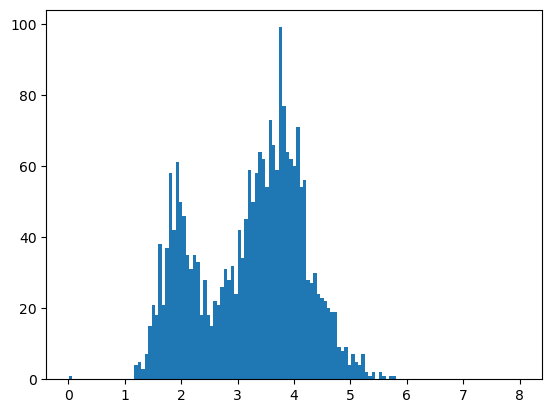

In [22]:
obs = lifetime_summary['Tau (green)']
_ = plt.hist(obs, range=(0.01, 8), bins=131)

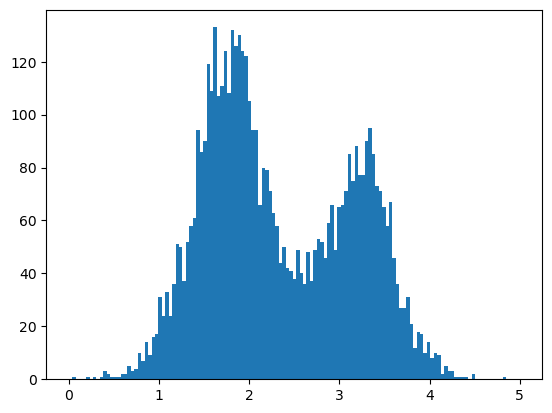

In [23]:
obs = lifetime_summary['Mean microtime (green)']
_ = plt.hist(obs, range=(0, 5), bins=131)

# Epxort and plot data

In [32]:
result = pd.concat([df, lifetime_summary], axis=1, join="inner")
result.to_csv(analysis_path / 'int_tau.csv', sep='\t')

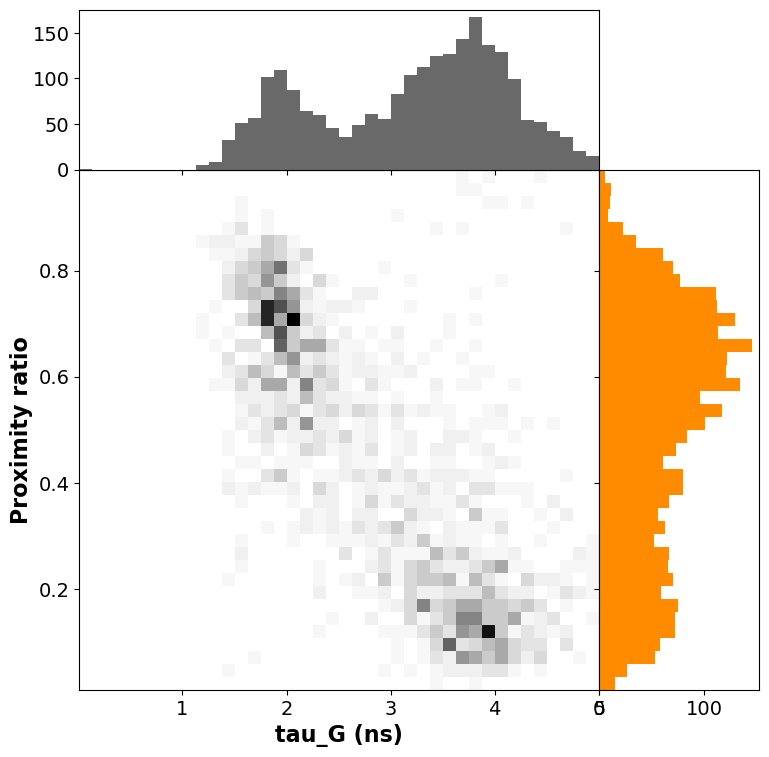

In [24]:
# Select parameter of interest & define axis range
x = lifetime_summary[f"Tau ({detector_name})"]
y = 1 / (1 + (df['Green Count Rate (KHz)']) / (df['Red Count Rate (KHz)']))

xlabel = "tau_G (ns)"
ylabel = "Proximity ratio"
range_x = [0.01, 5.0]
range_y = [0.01, 0.99]

make_2d_plot(
    x, y, range_x, range_y,
    pathlib.Path(analysis_path),
    xlabel, 
    ylabel,
    bins_x = 41,
    bins_y = 41
)

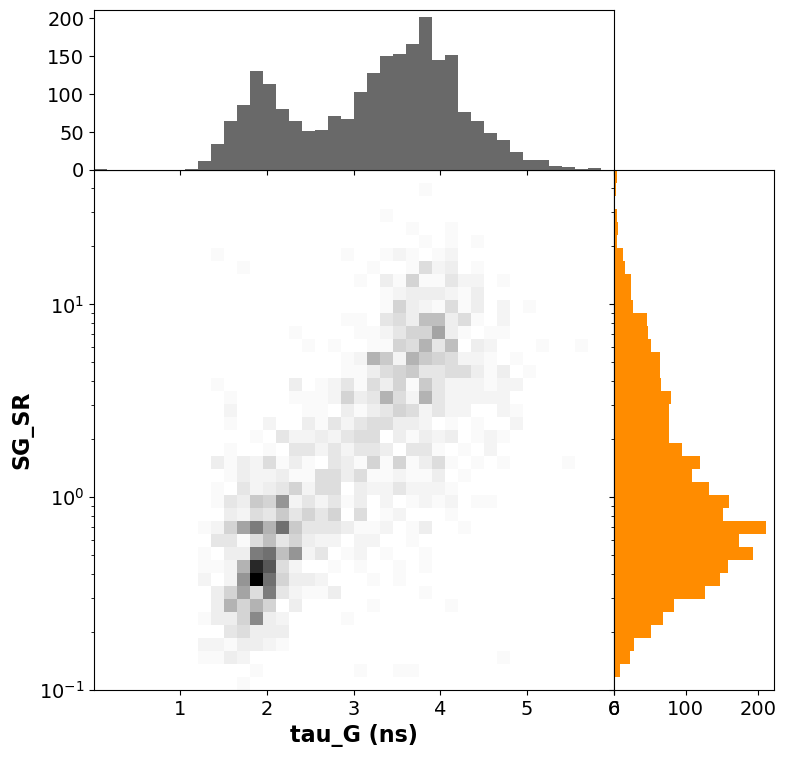

In [25]:
# Select parameter of interest & define axis range
x = lifetime_summary[f"Tau ({detector_name})"]
y = df['Green Count Rate (KHz)'] / df['Red Count Rate (KHz)']

xlabel = "tau_G (ns)"
ylabel = "SG_SR"
range_x = [0.01, 6.0]
range_y = [0.1, 50.]

make_2d_plot(
    x, y, range_x, range_y,
    pathlib.Path(analysis_path),
    xlabel, 
    ylabel,
    bins_x = 41,
    bins_y = 41,
    log_y=True
)

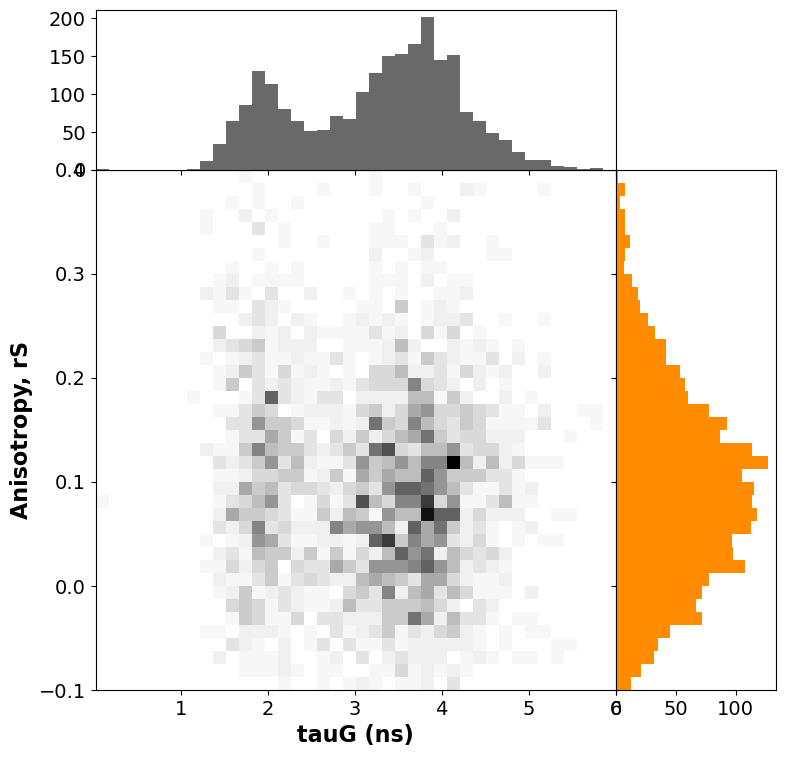

In [26]:
# Select parameter of interest & define axis range
x = lifetime_summary[f"Tau ({detector_name})"]
y = lifetime_summary[f"r Scatter ({detector_name})"]

xlabel = "tauG (ns)"
ylabel = "Anisotropy, rS"
range_x = [0.01, 6.0]
range_y = [-0.1, 0.4]

make_2d_plot(
    x, y, range_x, range_y,
    pathlib.Path(analysis_path),
    xlabel, 
    ylabel,
    bins_x = 41,
    bins_y = 41
)